## Exercise 2.1: Regression

Here we will follow the example given in the lecture for regression with polynomial basis functions.

Say we have a dataset with real measurements of two variables $x$ and $y$. We want to model the relationship between the variables.

To make the exercise pedagogical, the actual relationship is given to you: $y = \sin(x) + 10$. Experiments are substituted by a function that generates random points with some Gaussian smearing in the $y$ direction to simulate experimental uncertainty.

The data from the first experiment is in the file `regression_data.csv`.

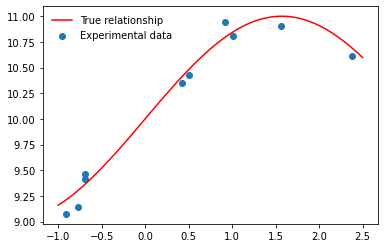

In [1]:
from scipy.stats import uniform as generator
from scipy.stats import norm as err
import pandas as pd
import numpy as np

def f(x):
    return 10 + np.sin(x)

def generate_data(N):
    x = generator.rvs(size=N)*3.5 - 1
    y = f(x) + err.rvs(scale = 0.1, size=N)
    return pd.DataFrame(data = {"x":x, "y":y})

df = pd.read_csv("regression_data.csv")

from matplotlib import pyplot as plt
plt.scatter(df["x"], df["y"], label = "Experimental data")
x_values = np.linspace(-1, 2.5, 100)
plt.plot(x_values, f(x_values), "r", label = "True relationship")
plt.legend(loc='best', frameon=False)
plt.show()

1) Perform curve fits to the data with polynomial functions of degree 1 to 8 and plot the predicted curve against the data points.

A polynomial of degree $n$ with coefficients $\vec{c} = (c_0, ... c_n)$ is simply
$$
f_n(x|\vec{c}) = \sum_{i=0}^n c_i x^i
$$

*Hint:* you can use [polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyfit.html) and [polyval](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyval.html) from NumPy.

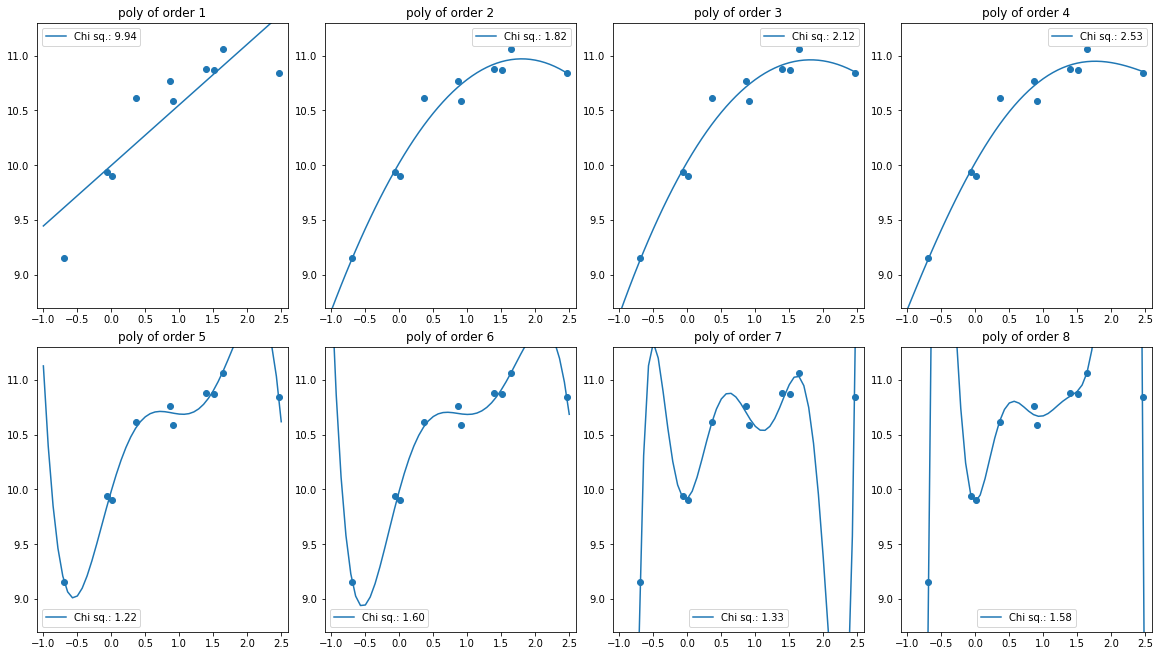

In [10]:
import scipy.optimize as so
import matplotlib.pyplot as plt

def poly_n(x, *args):
    c = args
    out = 0
    for i in range(len(c)):
        out += c[i] * x**i
    return out

fig, axes = plt.subplots(2, 4, figsize=(16, 9), constrained_layout=True)
popts = []
psigs = []

chisq_predicted = []

for i in range(1, 9):
    popt, pcov = so.curve_fit(poly_n, df['x'], df['y'], sigma=df['x']*0+0.1, absolute_sigma=True, p0=(i+1)*[1])
    popts.append(popt)
    psigs.append(np.sqrt(np.diag(pcov)))
    
    chisq = ((poly_n(df['x'], *popt) - df['y'])**2 / 0.1**2).sum() / (10-i-1)
    chisq_predicted.append(chisq)
    
    axes.flatten()[i-1].scatter(df['x'], df['y'])
    plt_x = np.linspace(-1., 2.5)
    axes.flatten()[i-1].plot(plt_x, poly_n(plt_x, *popt), label=f"Chi sq.: {chisq:.2f}")
    axes.flatten()[i-1].legend()
    axes.flatten()[i-1].set_title(f"poly of order {i}")
    axes.flatten()[i-1].set_xlim(-1.1, 2.6)
    axes.flatten()[i-1].set_ylim(8.7, 11.3)
    
plt.show()

Now we want to evaluate the relationship that we have 'learned' from the first dataset by evaluating the $\chi^2$ of the models over many repeated experiments, where $$\chi^2 \equiv \frac{(y_\text{obs} - y_\text{exp})^2}{y_\text{exp}}$$

2) a) For each of the fitted functions from the previous part, evaluate the $\chi^2$ on many (e.g. 100) new samples of equal size to the first.

You can use the `generate_data(N)` function defined in the first code cell.

Counter-intuitively, it's best to use the $y$ from the generated data as the "expected" value, and the predicted $y$ from the model as the "observed" value.

b) Plot the average test $\chi^2$ as a function of degree of the polynomial.

In [17]:
samples = 100
N = 10

chisq_sampled = np.zeros((8, samples))
for j in range(samples):
    df = generate_data(N)
    for i in range(1, 9):
        # using variance sigma^2 = 0.01
        chisq_sampled[i-1, j] = ((poly_n(df['x'], *popts[i-1]) - df['y'])**2 / 0.1**2).sum()  / (N-i)

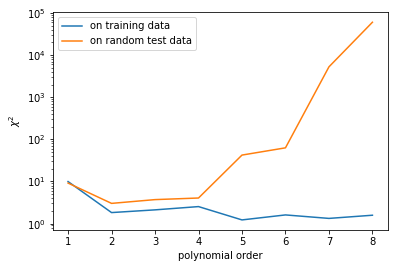

In [18]:
plt.plot(np.arange(1,9), np.array(chisq_predicted), label="on training data")
plt.plot(np.arange(1,9), chisq_sampled.mean(axis=1), label="on random test data")

plt.xlabel("polynomial order")
plt.ylabel(r"$\chi^2$")
plt.legend()
plt.yscale('log')